In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import yaml
from torchsummary import summary
from tqdm import tqdm

from torch.utils.data import DataLoader, Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision import transforms
import pandas as pd

from utils.classes import *

seed = 646
torch.manual_seed(seed=seed)
np.random.seed(seed=seed)
np.random.seed(seed=seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

batch_size = 8

In [2]:
CONDUCTANCE_VALUES = "2_"

# DIFFS_IMGS_TRAIN_PATH = "./data/eit/diffs_imgs_train.csv"
# DIFFS_IMGS_TEST_PATH = "./data/eit/diffs_imgs_test.csv"

DIFFS_IMGS_TRAIN_PATH = "./data/eit2/diffs_imgs_train_2.csv"
DIFFS_IMGS_TEST_PATH = "./data/eit2/diffs_imgs_test_2.csv"

# DIFFS_IMGS_TRAIN_PATH = "./data/eit4/diffs_imgs_train_4.csv"
# DIFFS_IMGS_TEST_PATH = "./data/eit4/diffs_imgs_test_4.csv"

# DIFFS_IMGS_TRAIN_PATH = "./data/eit6/diffs_imgs_train_6.csv"
# DIFFS_IMGS_TEST_PATH = "./data/eit6/diffs_imgs_test_6.csv"

# recon_path = "./models/img/14.2.1.20231116190651_img.pt"
recon_path = "./models/img/2_14.2.1.20231116193059_img.pt" #2
# recon_path = "./models/img/4_14.2.1.20231116190154_img.pt" #4
# recon_path = "./models/img/6_14.2.1.20231116190136_img.pt" #6

# v2lr_path = "./models/v2lr/0.20231116212748_v2lr.pt" 
v2lr_path = "./models/v2lr/2_1.2.1.1.20231117023937_v2lr.pt"  # "./models/v2lr/2_0.20231116212915_v2lr.pt" #2
# v2lr_path = "./models/v2lr/4_0" #4
# v2lr_path = "./models/v2lr/6_0.20231116213944_v2lr.pt" #6

In [3]:
diff_transform = transforms.Compose([
    transforms.ToTensor(),
])

img_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = DiffImg(csv_file=DIFFS_IMGS_TRAIN_PATH, diff_transform=diff_transform, img_transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataset = DiffImg(csv_file=DIFFS_IMGS_TEST_PATH, diff_transform=diff_transform, img_transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
v2lr = V2ImgLR().to(device)
criterion = nn.MSELoss()
optimizer_config = {'Adam': {'learning_rate':1e-3,'weight_decay':1e-5}}
optimizer = optimizer_build(optimizer_config,v2lr)
epochs = 100
recon = torch.load("./models/img/14.2.20231110000321.pt")
train_losses = []
for epoch in range(epochs):
    for i, (batch_diff, batch_img) in tqdm(enumerate(train_dataloader)):
        batch_diff = batch_diff.to(device)
        batch_img = batch_img.to(device)
        batch_mapped = v2lr(batch_diff)

        batch_encoded = recon.encoder[1:](batch_img)
        loss = criterion(batch_mapped, batch_encoded)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # if epoch % (10) == 0:
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.6f}')
    train_losses.append(loss.item())

In [ ]:
"""
IMAGE RECONSTRUCTION: evaluator
"""
model.eval()
with torch.no_grad():
    for i, (_ ,batch_img) in enumerate(train_dataloader):
        batch_img = batch_img.to(device)
        model = model.to(device)
        _, batch_recon = model(batch_img.float()) # convert input tensor to float
        if i==11:
            break
batch_recon=batch_recon.to('cpu').detach().numpy()
batch_img=batch_img.to('cpu').detach().numpy()

In [32]:
v2lr = torch.load(v2lr_path)
recon = torch.load(recon_path)


v2lr.eval()
with torch.no_grad():
    for i, (batch_diff, batch_img) in enumerate(train_dataloader):
        batch_diff = batch_diff.to(device)
        batch_img = batch_img.to(device)
        batch_mapped = v2lr(batch_diff)

        batch_recon = recon.decoder(batch_mapped)
        print(i)
        if i==10:
            break

batch_diff=batch_diff.to('cpu').detach().numpy()
batch_recon=batch_recon.to('cpu').detach().numpy()
batch_img=batch_img.to('cpu').detach().numpy()

0
1
2
3
4
5
6
7
8
9
10


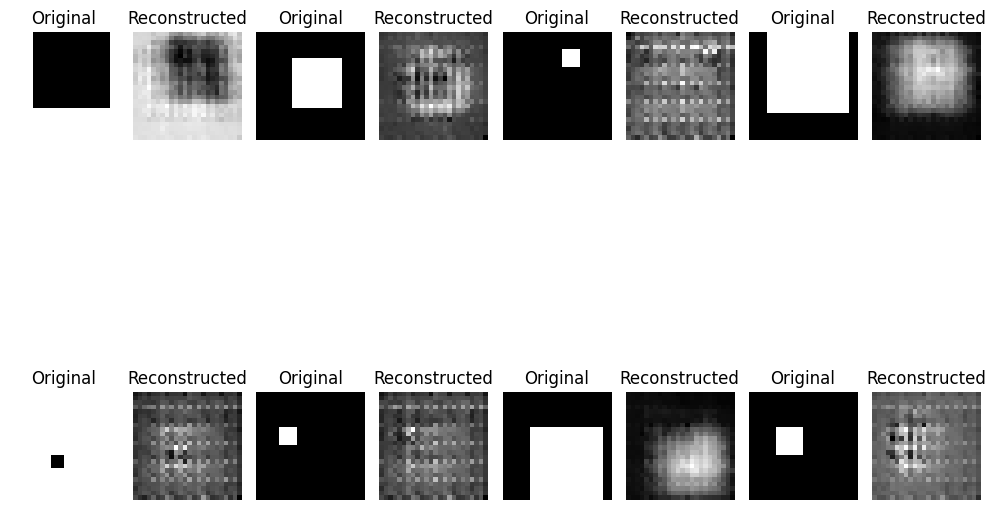

In [33]:
cols = 4
fig, ax = plt.subplots(2, cols*2, figsize=(10, 10))  # Create a larger subplot for all three sets
plt.subplots_adjust(wspace=0, hspace=0)

for i, (img, recon) in enumerate(zip(batch_img, batch_recon)):
    # Plot the diff image
    # ax[i // cols, i % cols * 3].imshow(np.random.randn(16,16), cmap='gray')
    # ax[i // cols, i % cols * 3].axis('off')

    # Plot the original image
    ax[i // cols, i % cols * 2].imshow(img.reshape(24,24), cmap='gray')
    ax[i // cols, i % cols * 2].axis('off')
    ax[i // cols, i % cols * 2].set_title('Original')

    # Plot the reconstructed image
    ax[i // cols, i % cols * 2 + 1].imshow(recon.reshape(24,24), cmap='gray')
    ax[i // cols, i % cols * 2 + 1].axis('off')
    ax[i // cols, i % cols * 2 + 1].set_title('Reconstructed')

# tight plot
plt.tight_layout()
plt.show()